In [2]:
import scipy
import scipy.sparse.linalg as linalg
import numpy as np

N = 10000

A = np.random.rand(N,N)
b = np.random.rand(N)

# A = np.zeros((N,N))
# for i in range(N//100):
#     x = np.random.rand(N)
#     A += np.exp(np.random.rand() * 10 - 5) * x @ x.T

In [3]:
x, errorcode = linalg.gmres(A,b,tol=1)

diff = A @ x - b
print(np.dot(diff, diff), max(diff))
print(errorcode)

819.037710188176 0.512154701155812
0


In [4]:
x = np.linalg.solve(A,b)

diff = A @ x - b
print(np.dot(diff, diff), max(diff))

1.4117638841154975e-18 5.444600326143245e-11


0:  |F(x)| = 23.9194; step 1
1:  |F(x)| = 8.79027; step 1
2:  |F(x)| = 4.3952; step 1
3:  |F(x)| = 1.07828; step 1
4:  |F(x)| = 0.0811349; step 1
5:  |F(x)| = 0.00532117; step 1
6:  |F(x)| = 0.000349539; step 1
7:  |F(x)| = 5.78463e-06; step 1
Residual 5.784630053184969e-06


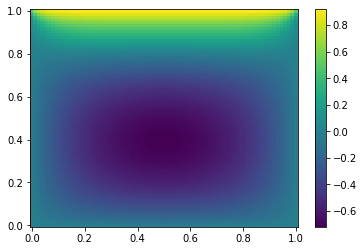

In [5]:
from scipy.optimize import newton_krylov
from numpy import cosh, zeros_like, mgrid, zeros

# parameters
nx, ny = 75, 75
hx, hy = 1./(nx-1), 1./(ny-1)

P_left, P_right = 0, 0
P_top, P_bottom = 1, 0

def residual(P):
    d2x = zeros_like(P)
    d2y = zeros_like(P)

    d2x[1:-1] = (P[2:]   - 2*P[1:-1] + P[:-2]) / hx/hx
    d2x[0]    = (P[1]    - 2*P[0]    + P_left)/hx/hx
    d2x[-1]   = (P_right - 2*P[-1]   + P[-2])/hx/hx

    d2y[:,1:-1] = (P[:,2:] - 2*P[:,1:-1] + P[:,:-2])/hy/hy
    d2y[:,0]    = (P[:,1]  - 2*P[:,0]    + P_bottom)/hy/hy
    d2y[:,-1]   = (P_top   - 2*P[:,-1]   + P[:,-2])/hy/hy

    return d2x + d2y - 10*cosh(P).mean()**2

# solve
guess = zeros((nx, ny), float)
sol = newton_krylov(residual, guess, method='lgmres', verbose=1)
print('Residual', abs(residual(sol)).max())

# visualize
import matplotlib.pyplot as plt
x, y = mgrid[0:1:(nx*1j), 0:1:(ny*1j)]
plt.pcolor(x, y, sol)
plt.colorbar()
plt.show()

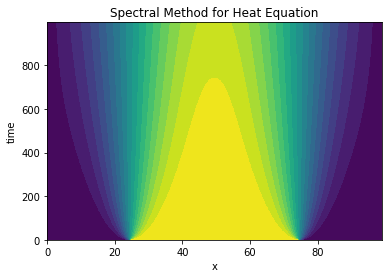

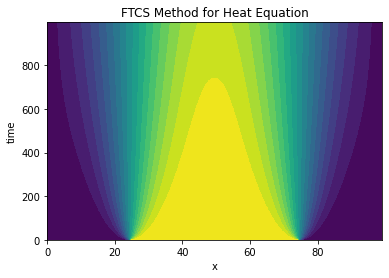

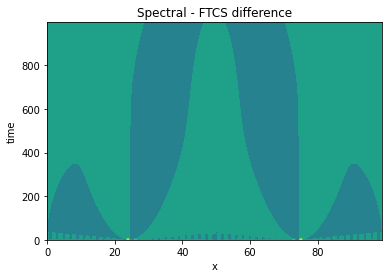

In [6]:
L = 100
T = 10
dt = 0.01

def Spectral(u0,t):
    lin   = np.linspace(u0[:,0], u0[:,-1], u0.shape[1],axis=1)           # take out the linear part (set boundaries to 0)
    uhat  = np.fft.rfft(np.concatenate((u0-lin,-(u0-lin)),-1))      # fourier transform of the padded signal (so boundaries are always 0) 
    freq  = 2 * np.pi * np.fft.rfftfreq(2*L)[np.newaxis,:]          # array of fourier frequencies 
    ts    = np.arange(0,t-dt,dt)[:,np.newaxis]
    uhat *= np.exp(-ts * 1e5 * freq**2/(L*L))                       # soln. to heat equation in frequency space
    return np.fft.irfft(uhat)[:,:L] + lin                           # add back the linear part (not affected by the heat equation)

def FTCS(u,t):
    for i in range(int(t//dt) - 1):
        u[i+1][1:-1] = u[i][1:-1] - 1e5*(2 * u[i][1:-1] - u[i][2:] - u[i][:-2]) * dt/(L*L)
    return u

A = np.zeros((int(T//dt),L))
A[:] = np.abs(np.linspace(-2,2,L)) < 1
B = np.zeros((int(T//dt),L))
B[0] = np.abs(np.linspace(-2,2,L)) < 1

A = Spectral(A,T)
B = FTCS(B,T)

levels = np.linspace(np.min(A), np.max(A), 20)

plt.contourf(A, levels, cmap='viridis')
plt.xlabel("x")
plt.ylabel("time")
plt.title("Spectral Method for Heat Equation")
plt.show()

plt.contourf(B, levels, cmap='viridis')
plt.xlabel("x")
plt.ylabel("time")
plt.title("FTCS Method for Heat Equation")
plt.show()

plt.contourf(A-B, cmap='viridis')
plt.xlabel("x")
plt.ylabel("time")
plt.title("Spectral - FTCS difference")
plt.show()

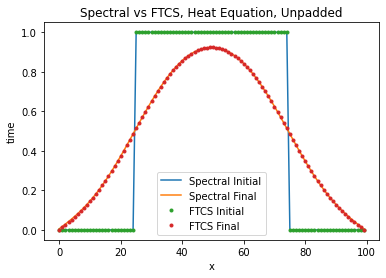

In [7]:
plt.plot(np.fft.irfft(np.fft.rfft(A[0])), label='Spectral Initial')
plt.plot(A[-1], label='Spectral Final')
plt.plot(B[0], '.', label='FTCS Initial')
plt.plot(B[-1], '.', label='FTCS Final')
plt.xlabel("x")
plt.ylabel("temperature")
plt.title("Spectral vs FTCS, Heat Equation, Unpadded")
plt.legend()
plt.show()

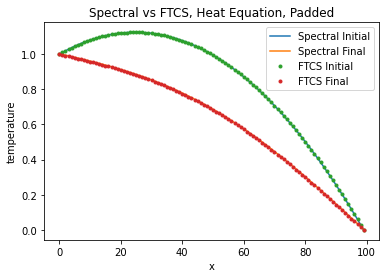

In [26]:
T = 100

def P_fft(u0,t):
    lin  = np.linspace(u0[0], u0[-1], u0.shape[0])
    uhat = np.fft.rfft(np.concatenate(((u0-lin), -(u0-lin))))
    k    = 2 * np.pi * np.fft.rfftfreq(2*L)
    uhat *= np.exp(-t * 1e5 * k**2/(L*L))
    return np.fft.irfft(uhat)[:L] + lin

def P_euler(u,steps):
    for _ in range(steps):
        u[1:-1] += - 1e5*(2 * u[1:-1] - u[2:] - u[:-2]) * dt/(L*L)
    return u

x = np.linspace(0,1,L)
Ai = 1 - x*(2*x-1)
Bi = 1 - x*(2*x-1)

Af = P_fft(Ai,T)
Bf = P_euler(Bi,int(T//dt))

plt.plot(P_fft(Ai,0), label='Spectral Initial')
plt.plot(Af, label='Spectral Final')
plt.plot(Ai, '.', label='FTCS Initial')
plt.plot(Bf, '.', label='FTCS Final')
plt.xlabel("x")
plt.ylabel("temperature")
plt.title("Spectral vs FTCS, Heat Equation, Padded")
plt.legend()
plt.show()

0:  |F(x)| = 1.9744e-05; step 1
1:  |F(x)| = 4.75632e-06; step 1
Residual 4.7563155529924475e-06


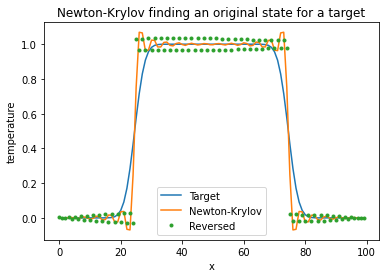

In [48]:
propagator = P_fft

T = 0.35
target = propagator(np.floor(1 - np.cos(np.linspace(0,2*np.pi,L))), T)

def residual(initial):
    return propagator(initial, T) - target

guess = target
sol = newton_krylov(residual, guess, method='lgmres', verbose=1, rdiff=1e-6)
print('Residual', abs(residual(sol)).max())

plt.plot(target, label='Target')
#plt.plot(guess, label='Guess')
plt.plot(sol, label='Newton-Krylov')
plt.plot(propagator(target,-T), '.', label='Reversed')
plt.xlabel("x")
plt.ylabel("temperature")
plt.title("Newton-Krylov finding an original state for a target")
plt.legend()
plt.show()

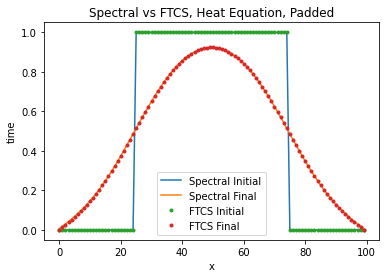

In [9]:
import jax
import jax.numpy as jnp
from jax import jit
from jax.numpy import pi

T = 10

@jit
def P_fft(u0,t):
    lin  = jnp.linspace(u0[0], u0[-1], u0.shape[0])
    uhat = jnp.fft.rfft(jnp.concatenate((u0-lin, -u0+lin)))
    freq = jnp.fft.rfftfreq(2*L)
    uhat *= jnp.exp(-t * 1e5 * (2*pi * freq)**2/(L*L))
    return jnp.fft.irfft(uhat).at[:L].get() + lin

def finite_step(i,u):
    return u.at[1:-1].add(- 1e5*(2 * u.at[1:-1].get() - u.at[2:].get() - u.at[:-2].get()) * dt/(L*L))

def P_euler(u,steps):
    return jax.lax.fori_loop(0,steps,finite_step,u)

Ai = jnp.floor(1 - jnp.cos(jnp.linspace(0,2*pi,L)))
Bi = jnp.floor(1 - jnp.cos(jnp.linspace(0,2*pi,L)))

Af = P_fft(Ai,T)
Bf = P_euler(Bi,int(T//dt))

plt.plot(P_fft(Ai,0), label='Spectral Initial')
plt.plot(Af, label='Spectral Final')
plt.plot(Bi, '.', label='FTCS Initial')
plt.plot(Bf, '.', label='FTCS Final')
plt.xlabel("x")
plt.ylabel("temperature")
plt.title("Spectral vs FTCS, Heat Equation, Padded")
plt.legend()
plt.show()